## Olympics Prediction Model

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install tensorflow[and-cuda]

In [ ]:
!pip install dython

In [47]:
!pip install scikit-metrics

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 147.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 232.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 248.5 MB/s eta 0:00:00
  Created wheel for scikit-metrics: filename=scikit_metrics-0.1.0-py3-none-any.whl size=4394 sha256=725614d93c858671c61fcf1e2b735e9d5d08141ee53d964774c005c68db74027
  Stored in directory: /tmp/pip-ephem-wheel-cache-oauna87t/wheels/53/be/d3/0efbe0f00adc8351cb1eee0bd923af7b5375007a50dda2f7f1
Successfully built scikit-metrics
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mosaic-utils 1.0.2 requires scikit

In [ ]:
import os
os._exit(00)

In [ ]:
# Import packages

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Matplotlib created a temporary cache directory at /tmp/matplotlib-3ddbcrkk because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Import Data

snowflake.get_connection(connection_name="ME_OLYMPICS_CNX")
data = get_dataframe("ATHLETE_EVENTS")
data

Exception occurred in getting snowflake connection: 'connectionSources'
Reading dataframe from snowflake native connector


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NA
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NA
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NA
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NA


In [4]:
data_bkp = get_dataframe("ATHLETE_EVENTS")
data_bkp

Reading dataframe from snowflake native connector


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NA
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NA
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NA
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NA


#EDA
data['AGE'].value_counts().to_dict()
data.info()
data['AGE'][data['AGE']!='NA'].astype(int).median()
data['WEIGHT'][data['WEIGHT']!='NA'].astype(float).median()
data['HEIGHT'][data['HEIGHT']!='NA'].astype(int).median()

In [5]:
data.columns = data.columns.str.lower()
#data.info()

In [6]:
data = data.drop(['id', 'name', 'games','event', 'noc', 'weight'], axis=1)

data['WEIGHT'] = data['WEIGHT'].replace('NA',str(float(data['WEIGHT'][data['WEIGHT']!='NA'].astype(float).median()))).astype(float)

data['WEIGHT'].value_counts().to_dict()

data.info()

In [7]:
data['age'] = data['age'].replace('NA',str(int(data['age'][data['age']!='NA'].astype(int).median()))).astype(int)

In [8]:
data['height'] = data['height'].replace('NA',str(int(data['height'][data['height']!='NA'].astype(int).median()))).astype(int)

In [9]:
tf.random.set_seed(100)

# CREATING LABELS

In [10]:
data['medal'].value_counts()

medal
NA        231333
Gold       13372
Bronze     13295
Silver     13116
Name: count, dtype: int64

In [11]:
data['medals']= data['medal'].map({'Gold': 3, 'Silver': 2 , 'Bronze': 1, 'NA' : 0}) 

data['medals'].value_counts()
data['medal'] = data['medal'].apply(lambda x: 1 if str(x) != 'nan' else 0)

In [12]:
# taking a copy of data at this stage
data_bkp_step2 = data.copy(deep= True)

In [ ]:
#Dropping columns as necessary,
#weight correlated with height, hence dropping

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   sex     271116 non-null  object
 1   age     271116 non-null  int64 
 2   height  271116 non-null  int64 
 3   team    271116 non-null  object
 4   year    271116 non-null  int16 
 5   season  271116 non-null  object
 6   city    271116 non-null  object
 7   sport   271116 non-null  object
 8   medal   271116 non-null  object
 9   medals  271116 non-null  int64 
dtypes: int16(1), int64(3), object(6)
memory usage: 19.1+ MB


In [14]:
data = data.drop(['medal'], axis=1)

In [ ]:
# data_bkp_step2.info()
# data['age'].value_counts()

# Cleaning data

In [15]:
# converting datatypes
data = data.astype({'age': int, 'height': int})
print(data.dtypes)

sex       object
age        int64
height     int64
team      object
year       int16
season    object
city      object
sport     object
medals     int64
dtype: object


In [16]:
#Checks
data.isna().mean()
print("Total missing values:", data.isna().sum().sum())

Total missing values: 0


In [17]:
data_bkp_step3= data.copy(deep= True)

In [ ]:
# data_bkp_step3.info()

In [18]:
data['year'].value_counts().sort_values()

year
1896      380
1904     1301
1906     1733
1900     1936
1908     3101
1994     3160
1932     3321
1998     3605
1912     4040
2002     4109
1920     4292
2006     4382
2010     4402
2014     4891
1928     5574
1924     5693
1956     6434
1936     7401
1948     7480
1980     8937
1960     9235
1952     9358
1964     9480
1968    10479
1976    10502
1984    11588
1972    11959
2012    12920
2004    13443
2008    13602
2016    13688
1996    13780
2000    13821
1988    14676
1992    16413
Name: count, dtype: int64

In [ ]:
# data['season'].value_counts()

In [19]:
data = data[data['season'] == 'Summer'].reset_index()

In [ ]:
#data['season'].value_counts()

In [20]:
data = data[data['year'] > 1960].reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158148 entries, 0 to 158147
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   level_0  158148 non-null  int64 
 1   index    158148 non-null  int64 
 2   sex      158148 non-null  object
 3   age      158148 non-null  int64 
 4   height   158148 non-null  int64 
 5   team     158148 non-null  object
 6   year     158148 non-null  int16 
 7   season   158148 non-null  object
 8   city     158148 non-null  object
 9   sport    158148 non-null  object
 10  medals   158148 non-null  int64 
dtypes: int16(1), int64(5), object(5)
memory usage: 12.4+ MB


In [21]:
data['year'].value_counts()

year
2000    13821
1996    13780
2016    13688
2008    13602
2004    13443
1992    12977
2012    12920
1988    12037
1972    10304
1984     9454
1976     8641
1968     8588
1964     7702
1980     7191
Name: count, dtype: int64

In [22]:
data = data.drop([ 'level_0', 'index'], axis=1)

In [23]:
data = data[data['sport'].map(data['sport'].value_counts()) > 3000]

In [24]:
data = data[data['team'].map(data['team'].value_counts()) > 2]

# Checks
data['sport'].value_counts()
data['medals'].value_counts()
data['year'].value_counts()

# Over all filters:
Season: Summer only
Year: >1960 only
SPorts that had more than 1500 values
Team: that had more than 2 values
    removed rep. columns like noc, event, etc.
    removing weight column as it is highly correlated to height column

In [25]:
#copy data
data_bkp_step4= data.copy(deep= True)

# Encoding Data

In [ ]:
# data['medals'].value_counts()

In [26]:
{column: len(data[column].unique()) for column in data.select_dtypes('object').columns}

{'sex': 2, 'team': 270, 'season': 1, 'city': 14, 'sport': 18}

In [27]:
data = data.drop(['season'], axis=1)

In [28]:
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

#df = binary_encode(
    f_data2,
    columns=['sex', 'season'],
    positive_values=['M', 'Summer']
)



In [29]:
df1 = onehot_encode(
    data,
    columns=['sex','team', 'city', 'sport'],
    prefixes=['sex','t', 'c', 's']
)

In [30]:
print("Remaining non-numeric columns:", len(df1.select_dtypes('object').columns))

Remaining non-numeric columns: 0


In [31]:
#df1['season'].info()

KeyError: 'season'

In [ ]:
#df1 = df1.drop(['season'], axis=1)

In [32]:
df1.reset_index()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136578 entries, 0 to 158147
Columns: 308 entries, age to s_Wrestling
dtypes: bool(304), int16(1), int64(3)
memory usage: 44.0 MB


# Visualizing Correlations

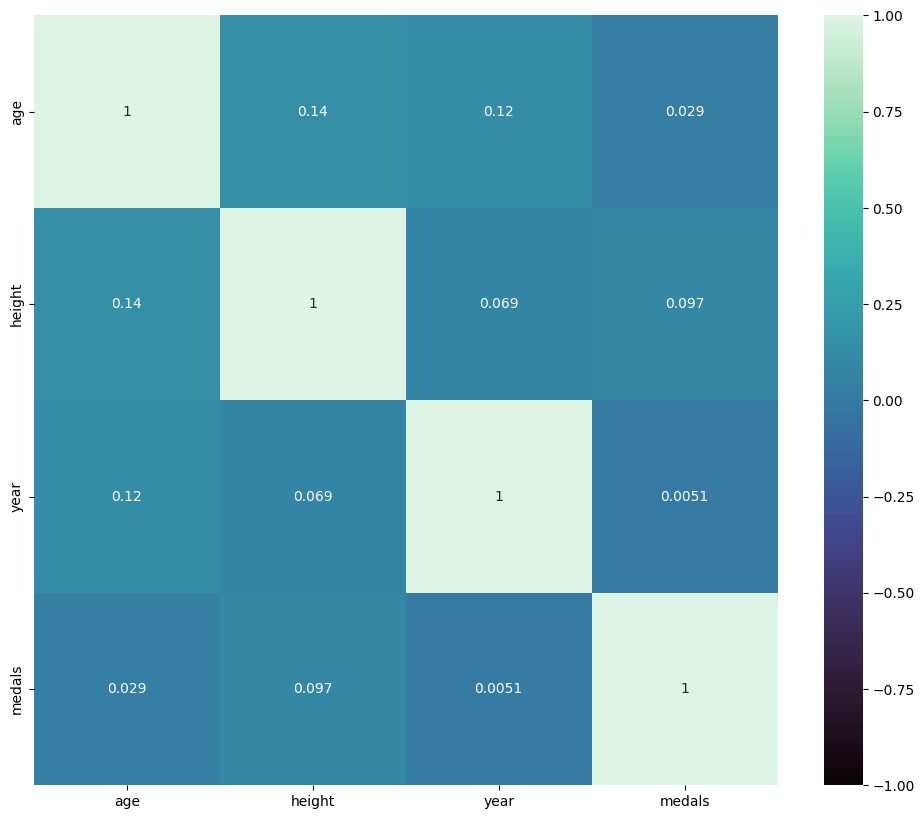

In [33]:
corr = df1.loc[:, :'medals'].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

In [ ]:
#grouped_data = data.groupby('team', 'sport')['medals'].sum()

# Splitting/Scaling

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136578 entries, 0 to 158147
Columns: 308 entries, age to s_Wrestling
dtypes: bool(304), int16(1), int64(3)
memory usage: 44.0 MB


In [ ]:
#medals = {'negative': 0,
#             'hypothyroid': 1, 
#             'hyperthyroid': 2}

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/tmp/pip_packages/sklearn/metrics/__init__.py)

In [39]:
y = df1['medals'].copy()
X = df1.drop('medals', axis=1).copy()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [41]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)

In [42]:
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [43]:
# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

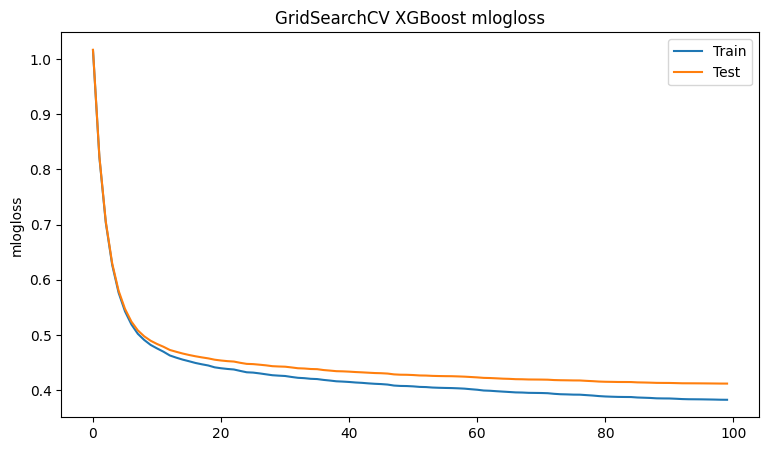

In [44]:
# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

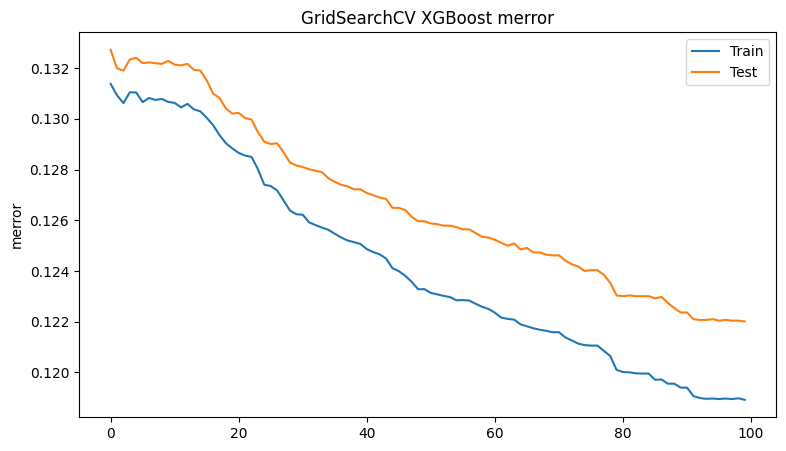

In [45]:
# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [46]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))


------------------ Confusion Matrix -----------------

[[29300     0     4    70]
 [ 1440   127    15    58]
 [ 1362     2   139    50]
 [ 1150     7     8   413]]

-------------------- Key Metrics --------------------


NameError: name 'accuracy_score' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

# Training

In [ ]:
X.shape

In [ ]:
print("Class Distribution (Positive to Negative): {:.1f}% / {:.1f}%".format(y_train.mean() * 100, (1 - y_train.mean()) * 100))

In [ ]:
inputs = tf.keras.Input(shape=(X.shape[1]))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=50,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

In [ ]:
y_train

# Results

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_true = np.array(y_test)
y_pred = np.squeeze(np.array(model.predict(X_test) >= 0.5, dtype=int))

In [ ]:
print("Classification Report:\n\n", classification_report(y_true, y_pred))

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
y_pred